# Const

In [1]:
FOLDER = "images"

OLD_TRAIN_DIR = f"{FOLDER}/Жуковский образцы почерка"
TRAIN_DIR = f"{FOLDER}/train"

OLD_TEST_DIR = f"{FOLDER}/Конволюты"
TEST_DIR = f"{FOLDER}/test"

NEW_TRAIN_DIR = f"{FOLDER}/new_train"
NEW_TEST_DIR = f"{FOLDER}/new_test"
IMG_SIZE = (3024, 4032)

DATA = "data"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

BATCH_SIZE = 8

# (3024, 4032) -> (x, 256)
(3024 * 256 / 4032, 256)
# int(3024/4), int(4032/4)

(192.0, 256)

# Библиотеки

In [39]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 900_000_000

import random

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

# import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import confusion_matrix as conf_matrix
import seaborn as sns

def open_image(image):
    # чтобы изображение не поворачивалось на 90 градусов, если w < h
    # https://stackoverflow.com/questions/4228530/pil-thumbnail-is-rotating-my-image
    img = Image.open(image)
    img = ImageOps.exif_transpose(img) 
    return img

# Папки train и test

In [6]:
!rm -r "$FOLDER"

rm: cannot remove 'images': No such file or directory


In [7]:
!tree -a

.
├── .git
│   ├── branches
│   ├── COMMIT_EDITMSG
│   ├── config
│   ├── description
│   ├── HEAD
│   ├── hooks
│   │   ├── applypatch-msg.sample
│   │   ├── commit-msg.sample
│   │   ├── fsmonitor-watchman.sample
│   │   ├── post-update.sample
│   │   ├── pre-applypatch.sample
│   │   ├── pre-commit.sample
│   │   ├── pre-merge-commit.sample
│   │   ├── prepare-commit-msg.sample
│   │   ├── pre-push.sample
│   │   ├── pre-rebase.sample
│   │   ├── pre-receive.sample
│   │   ├── push-to-checkout.sample
│   │   └── update.sample
│   ├── index
│   ├── info
│   │   └── exclude
│   ├── logs
│   │   ├── HEAD
│   │   └── refs
│   │       └── heads
│   │           └── master
│   ├── objects
│   │   ├── a2
│   │   │   └── e957306e2a9a0fdd4ff9c0bc39080e9e865070
│   │   ├── a8
│   │   │   └── b0b014debb4c106238d2c81acf254d26654a59
│   │   ├── df
│   │   │   └── 1da58fc94d283f959d9b87993dfaf837787f02
│   │   ├── e0
│   │   │   └── 8d0d93bbe8cd39348d26d0c458c2aee86f73af
│   │   ├── ed
│   │   │  

In [8]:
!unzip 'Жуковский образцы почерка.zip' -d "$FOLDER"
!unzip 'Конволюты.zip' -d "$FOLDER"

Archive:  Жуковский образцы почерка.zip
   creating: images/Жуковский образцы почерка/
  inflating: images/Жуковский образцы почерка/.DS_Store  
  inflating: images/__MACOSX/Жуковский образцы почерка/._.DS_Store  
   creating: images/Жуковский образцы почерка/1 Ранний почерк/
   creating: images/Жуковский образцы почерка/2 Зрелый почерк/
   creating: images/Жуковский образцы почерка/3 Поздний почерк/
   creating: images/Жуковский образцы почерка/1 Ранний почерк/Жуковский к Протасовым (хороший почерк). 1 апреля 1814. ИРЛИ. Р. 1. Оп. 9. № 83/
  inflating: images/Жуковский образцы почерка/1 Ранний почерк/.DS_Store  
  inflating: images/__MACOSX/Жуковский образцы почерка/1 Ранний почерк/._.DS_Store  
  inflating: images/Жуковский образцы почерка/1 Ранний почерк/Жуковский к Тургеневу и Блудову (обычный почерк). 28 января 1807. РНБ. Ф. 286. Оп. 2. № 143.pdf  
  inflating: images/__MACOSX/Жуковский образцы почерка/1 Ранний почерк/._Жуковский к Тургеневу и Блудову (обы

In [11]:
!rm -r "$FOLDER"/__MACOSX

In [12]:
# удаление всех docx файлов
# https://recoverit.wondershare.com/file-recovery/linux-remove-directory-recursively.html
!find ./"$FOLDER" -type f -name '*.docx' -print -delete

./images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1.docx
./images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676.docx
./images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Плетневу и Вяземскому (плохой почерк). 1847. ИРЛИ. № 27763.docx
./images/Жуковский образцы почерка/1 Ранний почерк/Жуковский к Тургеневу и Блудову (обычный почерк). 28 января 1807. РНБ. Ф. 286. Оп. 2. № 143.docx
./images/Жуковский образцы почерка/1 Ранний почерк/Жуковский к Протасовым (хороший почерк). 1 апреля 1814. ИРЛИ. Р. 1. Оп. 9. № 83.docx
./images/Жуковский образцы почерка/2 Зрелый почерк/Жуковский к Воейковой (обычный почерк). 1821. ИРЛИ. Р. 3. Оп. 1. № 1109.docx
./images/Жуковский образцы почерка/2 Зрелый почерк/Жуковский к неизвестному (Вяземскому? плохой почерк). Б.д. ИРЛИ. № 2882.docx
./images/Жуковский образцы п

In [13]:
# удаление скрытых файлов
!find ./"$FOLDER" -type f -name '.*' -print -delete

./images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676/.DS_Store
./images/Жуковский образцы почерка/3 Поздний почерк/.DS_Store
./images/Жуковский образцы почерка/1 Ранний почерк/.DS_Store
./images/Жуковский образцы почерка/2 Зрелый почерк/.DS_Store
./images/Жуковский образцы почерка/.DS_Store
./images/Конволюты/.DS_Store


In [14]:
!tree -L 2

.
├── images
│   ├── Жуковский образцы почерка
│   └── Конволюты
├── Zhukovsky.ipynb
├── Жуковский образцы почерка.zip
└── Конволюты.zip

3 directories, 3 files


In [15]:
# перевод pdf файлов в jpg
for dirpath, dirnames, filenames in os.walk(FOLDER):
    # print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")

    for fname in filenames:
        root, ext = os.path.splitext(fname) # ('Жуковский (обычный почерк)', '.pdf')
        fpath = os.path.join(dirpath, fname)

        if ext in {".jpeg", ".JPG", ".jpg"}:
            continue
        elif ext == ".pdf":
            print(f"--- Сonversion of '{fname}' ---")
            print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")
            # !echo "$fname"
            !pdftoppm -jpeg -r 600 "$fpath" "$dirpath"/"$root"
            !du -h "$fpath"
            !du -h "$dirpath"/"$root"-1.jpg
            !rm "$fpath"
        else:
            print("!!!!!!!!!!!!")

        print("\n")

--- Сonversion of 'Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1.pdf' ---
dirpath = 'images/Жуковский образцы почерка/3 Поздний почерк',
dirnames = ['Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676', 'Жуковский к Плетневу и Вяземскому (плохой почерк). 1847. ИРЛИ. № 27763'],
filenames = ['Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1.pdf']

2,0M	images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1.pdf
5,2M	images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1-1.jpg


--- Сonversion of 'Жуковский к Тургеневу и Блудову (обычный почерк). 28 января 1807. РНБ. Ф. 286. Оп. 2. № 143.pdf' ---
dirpath = 'images/Жуковский образцы почерка/1 Ранний почерк',
dirnames = ['Жуковский к Протасовым (хороший почерк). 1 апреля 18

In [16]:
# есть в папке только файлы, то перенумеруем их

for dirpath, dirnames, filenames in os.walk(FOLDER):
    
    if len(dirnames) == 0: # если внутри нет папок
        for i, fname in enumerate(sorted(filenames)):
            _, ext = os.path.splitext(fname) # ('Жуковский (обычный почерк)', '.pdf')
            fpath = os.path.join(dirpath, fname)
            
            new_fpath = os.path.join(dirpath, str(i)) + ext

            print(f"--- Сonversion of '{fname}' to '{i}' ---")
            print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")
            
            !mv "$fpath" "$new_fpath"

        print("\n")

--- Сonversion of 'eaa0291_001_0008676_00001.JPG' to '0' ---
dirpath = 'images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676',
dirnames = [],
filenames = ['eaa0291_001_0008676_00001.JPG', 'eaa0291_001_0008676_00005.JPG', 'eaa0291_001_0008676_00002.JPG', 'eaa0291_001_0008676_00004.JPG']

--- Сonversion of 'eaa0291_001_0008676_00002.JPG' to '1' ---
dirpath = 'images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676',
dirnames = [],
filenames = ['eaa0291_001_0008676_00001.JPG', 'eaa0291_001_0008676_00005.JPG', 'eaa0291_001_0008676_00002.JPG', 'eaa0291_001_0008676_00004.JPG']

--- Сonversion of 'eaa0291_001_0008676_00004.JPG' to '2' ---
dirpath = 'images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676',
dirnames = [],
filenames = ['eaa0291_001_0008676_00001.JPG', 'e

## train

In [17]:
!rm -r "$TRAIN_DIR"

rm: cannot remove 'images/train': No such file or directory


In [18]:
!mkdir "$TRAIN_DIR"

In [19]:
# формирование train из "Жуковский образцы почерка"

for dirpath, dirnames, filenames in os.walk(OLD_TRAIN_DIR):
    # print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")

    for fname in filenames:
        _, ext = os.path.splitext(fname)
        fpath = os.path.join(dirpath, fname)

        # print(f"\n{dirpath = },\n{dirnames = },\n{filenames = },\n{fpath = }")

        splitpath = re.split(r"/", fpath) 
        # ['data', 'Жуковский образцы почерка', '3 Поздний почерк', 'Жуковский (обычный почерк).jpg']
        splitpath[-1] = os.path.splitext(splitpath[-1])[0] 
        # ['data', 'Жуковский образцы почерка', '3 Поздний почерк', 'Жуковский (обычный почерк)']
        
        for i, elem in enumerate(splitpath):
            inx_left_bracket = elem.find("(")
            inx_right_bracket = elem.rfind(")")

            if (inx_left_bracket != -1) and (inx_right_bracket != -1):
                splitpath[i] = elem[inx_left_bracket : inx_right_bracket + 1]

        new_fpath = os.path.join(TRAIN_DIR, "-".join(splitpath[2:])) + ext

        print(f"--- Copying of\n{fpath}\nto\n{new_fpath}\n---")

        !cp "$fpath" "$new_fpath"

--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1-1.jpg
to
images/train/3 Поздний почерк-(обычный почерк).jpg
---
--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676/1.JPG
to
images/train/3 Поздний почерк-(хороший почерк)-1.JPG
---
--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676/2.JPG
to
images/train/3 Поздний почерк-(хороший почерк)-2.JPG
---
--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676/0.JPG
to
images/train/3 Поздний почерк-(хороший почерк)-0.JPG
---
--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 

## test

In [20]:
!rm -r "$TEST_DIR"

rm: cannot remove 'images/test': No such file or directory


In [21]:
!mkdir "$TEST_DIR"

In [22]:
# формирование test из "Конволюты"

for dirpath, dirnames, filenames in os.walk(OLD_TEST_DIR):
    # print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")

    for fname in filenames:
        _, ext = os.path.splitext(fname)
        fpath = os.path.join(dirpath, fname)

        splitpath = re.split(r"/", fpath)
        # ['data', 'Конволюты', 'РГИА. Ф. 472. Оп. 1. № 662. О жалованье', '4.JPG']
        splitpath[-1] = os.path.splitext(splitpath[-1])[0] 
        # ['data', 'Конволюты', 'РГИА. Ф. 472. Оп. 1. № 662. О жалованье', '4']

        # print(f"\n{fpath = },\n{splitpath = }\n")
        
        for i, elem in enumerate(splitpath):
            inx_left = elem.find("№")
            inx_right = elem.find(".", inx_left)
            inx_right_new = elem.find(" ", inx_left + 2) # РГИА. Ф. 722. Оп. 1. № 2013 О С5/27
            
            if inx_right == -1 or inx_right_new < inx_right:
                inx_right = inx_right_new
            
            if (inx_left != -1) and (inx_right != -1):
                splitpath[i] = elem[inx_left+2 : inx_right]

        new_fpath = os.path.join(TEST_DIR, "-".join(splitpath[2:])) + ext

        print(f"--- Copying of\n{fpath}\nto\n{new_fpath}\n---")

        !cp "$fpath" "$new_fpath"

--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/4.JPG
to
images/test/662-4.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/1.JPG
to
images/test/662-1.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/2.JPG
to
images/test/662-2.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/6.JPG
to
images/test/662-6.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/0.JPG
to
images/test/662-0.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/8.JPG
to
images/test/662-8.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/5.JPG
to
images/test/662-5.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/3.JPG
to
images/test/662-3.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/7.JPG
to
images/test/662-7.JPG
---
--- Copying of
images/Конволюты/РГИА.

## new_train (resize train)

In [39]:
!tree -L 2

.
├── data
│   ├── 0
│   └── 1
├── images
│   ├── new_test
│   ├── new_train
│   ├── test
│   ├── train
│   ├── Жуковский образцы почерка
│   └── Конволюты
├── Zhukovsky.ipynb
├── Жуковский образцы почерка.zip
└── Конволюты.zip

10 directories, 3 files


In [40]:
!rm -r "$NEW_TRAIN_DIR"

In [41]:
!mkdir "$NEW_TRAIN_DIR"

In [42]:
# https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size[0] - img.size[0]
    delta_height = desired_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def resize_with_padding(img, expected_size):
    img.thumbnail(expected_size)
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

In [44]:
train_files = sorted(os.listdir(path=TRAIN_DIR))
test_files = sorted(os.listdir(path=TEST_DIR))

In [45]:
for name in train_files[:5]:
    img = open_image(os.path.join(TRAIN_DIR, name))
    w, h = img.size
    print(f"{name:60} - {w} x {h}")

1 Ранний почерк-(обычный почерк).jpg                       - 21334 x 10242
1 Ранний почерк-(хороший почерк)-0.jpg                     - 1962 x 1169
1 Ранний почерк-(хороший почерк)-1.jpg                     - 2274 x 2941
1 Ранний почерк-(хороший почерк)-2.jpg                     - 2274 x 2941
1 Ранний почерк-(хороший почерк)-3.jpg                     - 2286 x 1564


In [46]:
for name in test_files[:5]:
    img = open_image(os.path.join(TEST_DIR, name))
    w, h = img.size
    print(f"{name:13} - {w} x {h}")

122-0.JPG     - 3024 x 4032
122-1.JPG     - 3024 x 4032
122-10.JPG    - 3024 x 4032
122-11.JPG    - 3024 x 4032
122-2.JPG     - 3024 x 4032


In [48]:
# resize в папку NEW_TRAIN_DIR
for i, name in enumerate(train_files):
    img = open_image(os.path.join(TRAIN_DIR, name))
    size_old = img.size

    if min(size_old) > 10000:
        # img = resize_with_padding(img, IMG_SIZE)
        img.thumbnail(IMG_SIZE)
    
    img.save(os.path.join(NEW_TRAIN_DIR, name))

    print(f"{i:2} - {size_old} \t-> {img.size}")

 0 - (21334, 10242) 	-> (3024, 1452)
 1 - (1962, 1169) 	-> (1962, 1169)
 2 - (2274, 2941) 	-> (2274, 2941)
 3 - (2274, 2941) 	-> (2274, 2941)
 4 - (2286, 1564) 	-> (2286, 1564)
 5 - (854, 625) 	-> (854, 625)
 6 - (1052, 1165) 	-> (1052, 1165)
 7 - (1440, 869) 	-> (1440, 869)
 8 - (1440, 853) 	-> (1440, 853)
 9 - (1440, 1671) 	-> (1440, 1671)
10 - (1440, 858) 	-> (1440, 858)
11 - (1904, 2601) 	-> (1904, 2601)
12 - (2152, 1448) 	-> (2152, 1448)
13 - (2293, 1598) 	-> (2293, 1598)
14 - (1607, 2488) 	-> (1607, 2488)
15 - (21334, 10325) 	-> (3024, 1464)
16 - (3992, 3156) 	-> (3992, 3156)
17 - (3992, 3156) 	-> (3992, 3156)
18 - (3992, 3156) 	-> (3992, 3156)
19 - (2214, 3683) 	-> (2214, 3683)
20 - (5616, 3744) 	-> (5616, 3744)
21 - (5616, 3744) 	-> (5616, 3744)
22 - (5616, 3744) 	-> (5616, 3744)


In [49]:
# img = open_image(os.path.join(TRAIN_DIR, train_files[5]))
# print(img.size)
# img
# width, height = im.size
# im = im.resize((100, 300))
# im

In [50]:
# img.thumbnail((1000, 1000))
# print(img.size)
# img

## new_test (resize test)

In [51]:
!tree -L 2

.
├── data
│   ├── 0
│   └── 1
├── images
│   ├── new_test
│   ├── new_train
│   ├── test
│   ├── train
│   ├── Жуковский образцы почерка
│   └── Конволюты
├── Zhukovsky.ipynb
├── Жуковский образцы почерка.zip
└── Конволюты.zip

10 directories, 3 files


In [52]:
!rm -r "$NEW_TEST_DIR"

In [53]:
!mkdir "$NEW_TEST_DIR"

In [54]:
# resize в папку NEW_TEST_DIR
for name in test_files:
    img = open_image(os.path.join(TEST_DIR, name))
    size_old = img.size    
    # img = resize_with_padding(img, IMG_SIZE)
    
    img.save(os.path.join(NEW_TEST_DIR, name))

    # print(f"{size_old} \t-> {img.size}")

## data

In [55]:
!rm -r "$DATA"

In [56]:
! mkdir "$DATA"

In [57]:
!cp -r "$NEW_TRAIN_DIR" "$DATA_POS"

In [58]:
!cp -r "$NEW_TEST_DIR" "$DATA_NEG"

In [59]:
!tree -L 2

.
├── data
│   ├── 0
│   └── 1
├── images
│   ├── new_test
│   ├── new_train
│   ├── test
│   ├── train
│   ├── Жуковский образцы почерка
│   └── Конволюты
├── Zhukovsky.ipynb
├── Жуковский образцы почерка.zip
└── Конволюты.zip

10 directories, 3 files


## Crop pos image (вручную)

In [74]:
files_names = sorted(os.listdir(DATA_POS))
image_paths = [os.path.join(DATA_POS, i) for i in files_names]
for i, im in enumerate(image_paths):
    size = np.asarray(Image.open(im)).shape
    print(f"{i:2} - {files_names[i]:60} - {size}")

 0 - 1 Ранний почерк-(обычный почерк).jpg                       - (1452, 2200, 3)
 1 - 1 Ранний почерк-(хороший почерк)-0.jpg                     - (1169, 1962, 3)
 2 - 1 Ранний почерк-(хороший почерк)-1.jpg                     - (2941, 2274, 3)
 3 - 1 Ранний почерк-(хороший почерк)-2.jpg                     - (2941, 2274, 3)
 4 - 1 Ранний почерк-(хороший почерк)-3.jpg                     - (1564, 2286, 3)
 5 - 2 Зрелый почерк-(Вяземскому? плохой почерк)-0.jpg          - (625, 854, 3)
 6 - 2 Зрелый почерк-(Вяземскому? плохой почерк)-1.jpg          - (1165, 1052, 3)
 7 - 2 Зрелый почерк-(идеальный почерк)-0.jpeg                  - (869, 1440, 3)
 8 - 2 Зрелый почерк-(идеальный почерк)-1.jpeg                  - (853, 1440, 3)
 9 - 2 Зрелый почерк-(идеальный почерк)-2.jpeg                  - (1671, 1440, 3)
10 - 2 Зрелый почерк-(идеальный почерк)-3.jpeg                  - (858, 800, 3)
11 - 2 Зрелый почерк-(обычный почерк)-0.jpg                     - (2601, 1904, 3

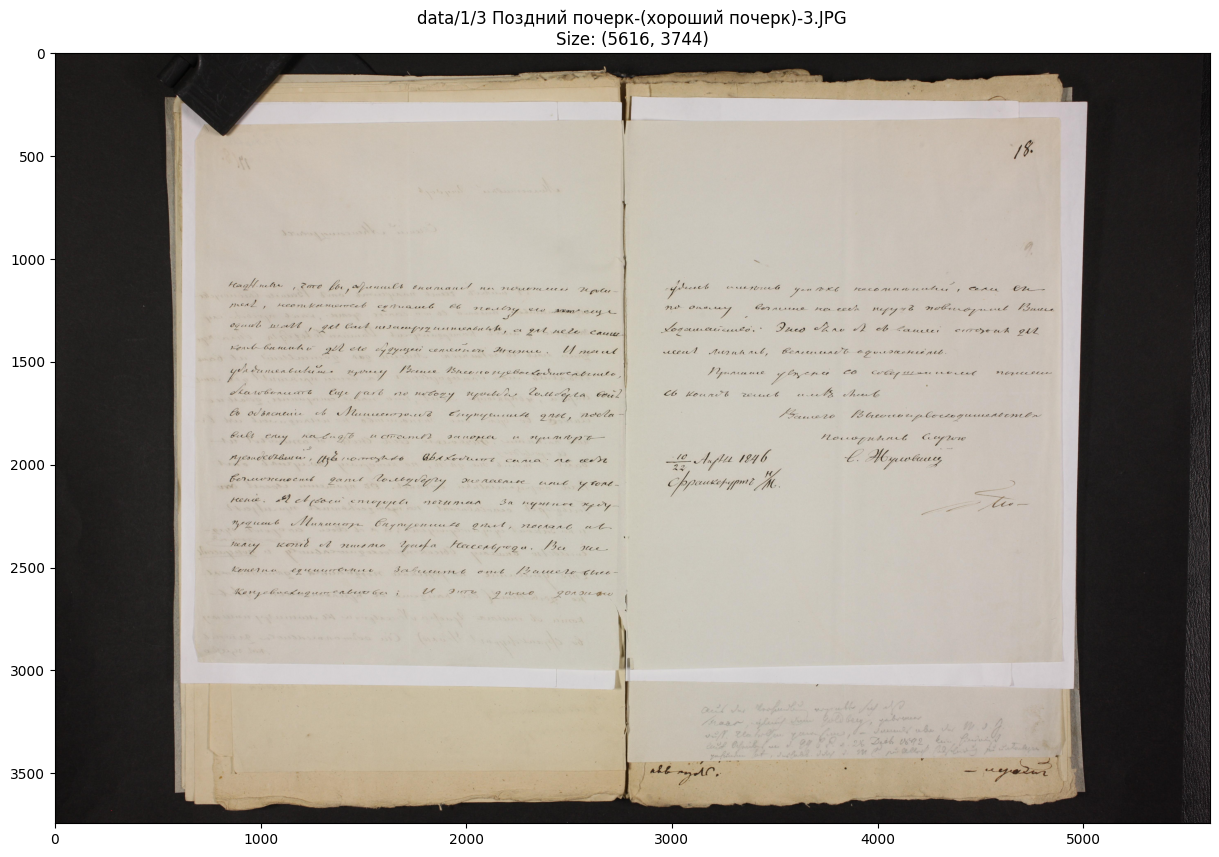

In [96]:
# 0, 10, 15, 19, 20, 21, 22
image_path = image_paths[22]

# for image_path in image_paths:
im = Image.open(image_path)
plt.figure(figsize=(15, 10))
plt.title(f"{image_path}\nSize: {im.size}")
plt.imshow(im) 
plt.show()

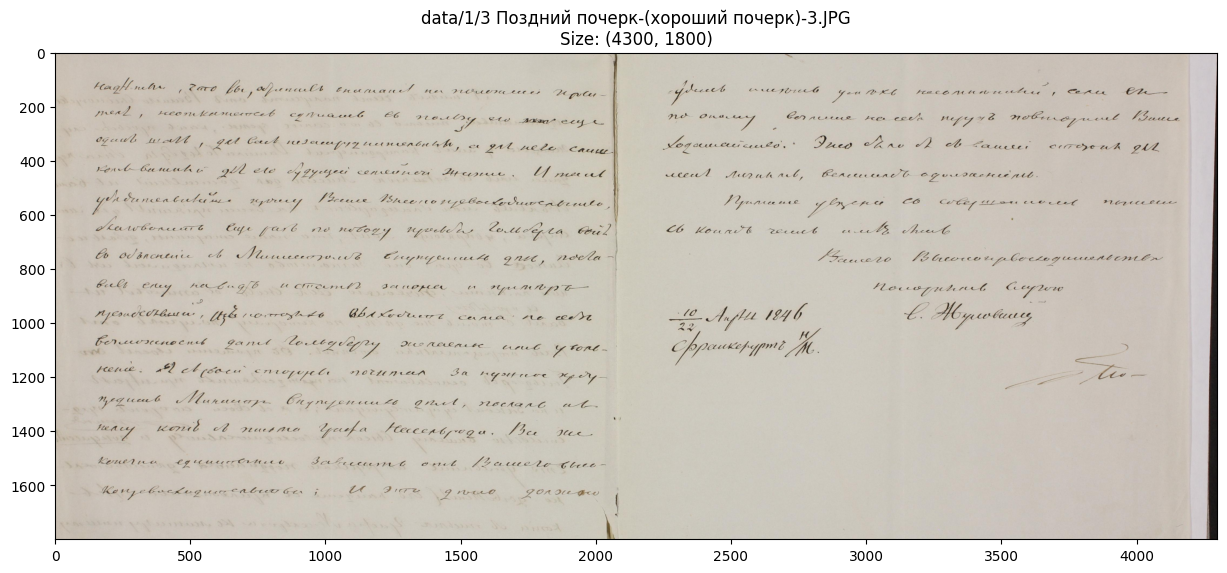

In [100]:
width, height = im.size
left = 700
right = 5000
top, bottom = 1000, 2800
im1 = im.crop((left, top, right, bottom))
# im1.show()
plt.figure(figsize=(15, 10))
plt.title(f"{image_path}\nSize: {im1.size}")
plt.imshow(im1) 
plt.show()

In [101]:
im1.save(image_path)

## Resize pos и neg

In [9]:
!rm -r "$DATA_POS"

In [10]:
!cp -r pos "$DATA_POS"

In [11]:
files_names1 = sorted(os.listdir(DATA_POS))
files_names2 = sorted(os.listdir(DATA_NEG))

image_paths  = [os.path.join(DATA_POS, i) for i in files_names1]
image_paths += [os.path.join(DATA_NEG, i) for i in files_names2]

for i, image_path in enumerate(image_paths):
    img = open_image(image_path)
    size_old = img.size
    
    img.thumbnail((1000, 1000))
    
    img.save(image_path)

    if i < 25:
        print(f"{i:3} - {size_old} \t-> {img.size}")

  0 - (2200, 1452) 	-> (1000, 660)
  1 - (1962, 1169) 	-> (1000, 596)
  2 - (2274, 2941) 	-> (773, 1000)
  3 - (2274, 2941) 	-> (773, 1000)
  4 - (2286, 1564) 	-> (1000, 684)
  5 - (854, 625) 	-> (854, 625)
  6 - (1052, 1165) 	-> (903, 1000)
  7 - (1440, 869) 	-> (1000, 603)
  8 - (1440, 853) 	-> (1000, 592)
  9 - (1440, 1671) 	-> (862, 1000)
 10 - (800, 858) 	-> (800, 858)
 11 - (1904, 2601) 	-> (732, 1000)
 12 - (2152, 1448) 	-> (1000, 673)
 13 - (2293, 1598) 	-> (1000, 697)
 14 - (1607, 2488) 	-> (646, 1000)
 15 - (2000, 1464) 	-> (1000, 732)
 16 - (3992, 3156) 	-> (1000, 791)
 17 - (3992, 3156) 	-> (1000, 791)
 18 - (3992, 3156) 	-> (1000, 791)
 19 - (2214, 2500) 	-> (886, 1000)
 20 - (4300, 2300) 	-> (1000, 535)
 21 - (4000, 2800) 	-> (1000, 700)
 22 - (4300, 1800) 	-> (1000, 419)
 23 - (750, 1000) 	-> (750, 1000)
 24 - (750, 1000) 	-> (750, 1000)


In [13]:
for i, image_path in enumerate(image_paths):
    img = open_image(image_path)

    if i < 30:
        print(f"{i:3} - {img.size}")

  0 - (1000, 660)
  1 - (1000, 596)
  2 - (773, 1000)
  3 - (773, 1000)
  4 - (1000, 684)
  5 - (854, 625)
  6 - (903, 1000)
  7 - (1000, 603)
  8 - (1000, 592)
  9 - (862, 1000)
 10 - (800, 858)
 11 - (732, 1000)
 12 - (1000, 673)
 13 - (1000, 697)
 14 - (646, 1000)
 15 - (1000, 732)
 16 - (1000, 791)
 17 - (1000, 791)
 18 - (1000, 791)
 19 - (886, 1000)
 20 - (1000, 535)
 21 - (1000, 700)
 22 - (1000, 419)
 23 - (750, 1000)
 24 - (750, 1000)
 25 - (750, 1000)
 26 - (750, 1000)
 27 - (750, 1000)
 28 - (750, 1000)
 29 - (750, 1000)


# torchvision.transforms

In [3]:
data_transform = transforms.Compose([
    # transforms.Resize(size=(224, 224)),
    transforms.RandomCrop(300),
    # Flip the images randomly on the horizontal
    # transforms.RandomHorizontalFlip(p=1), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])


# tranf = transforms.Compose([
#         # transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
#         # transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
#         transforms.RandomCrop(224)
#         # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
#         transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
#         # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
#     ])

In [4]:
# https://www.learnpytorch.io/04_pytorch_custom_datasets/

def plot_transformed_images(image_paths, transform, n=3):
    
    random_image_paths = random.sample(image_paths, k=n)

    # random_image_paths = image_paths
                             
    for image_path in random_image_paths:
        
        f = Image.open(image_path)
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].imshow(f) 
        ax[0].set_title(f"Original \nSize: {f.size}")
        # ax[0].axis("off")

        # Transform and plot image
        # Note: permute() will change shape of image to suit matplotlib 
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        transformed_image = transform(f).permute(1, 2, 0) 
        ax[1].imshow(transformed_image) 
        ax[1].set_title(f"Transformed \nSize: {transformed_image.size()}")
        # ax[1].axis("off")

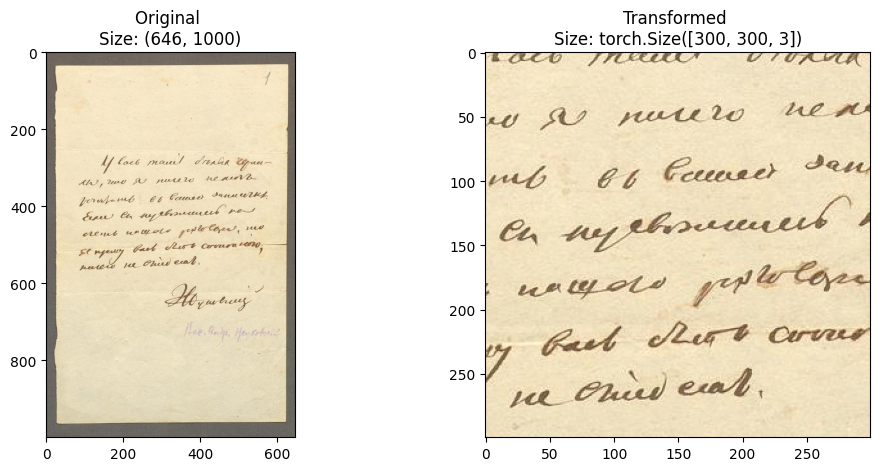

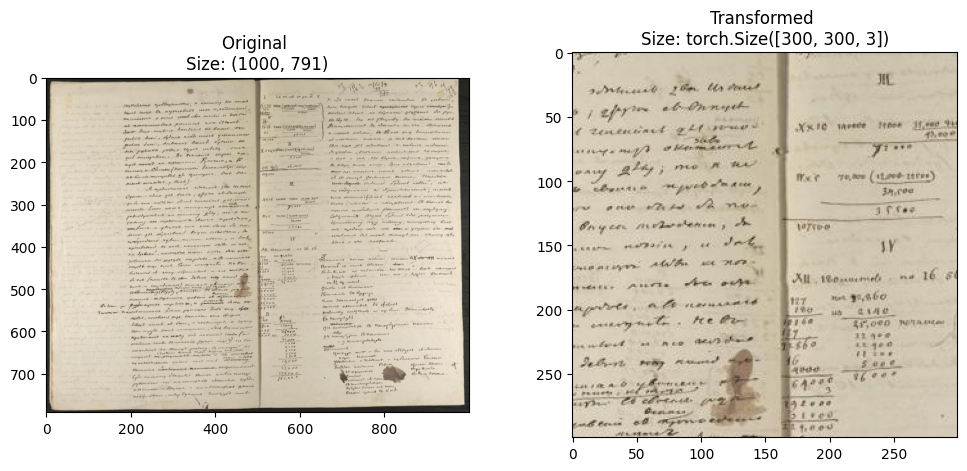

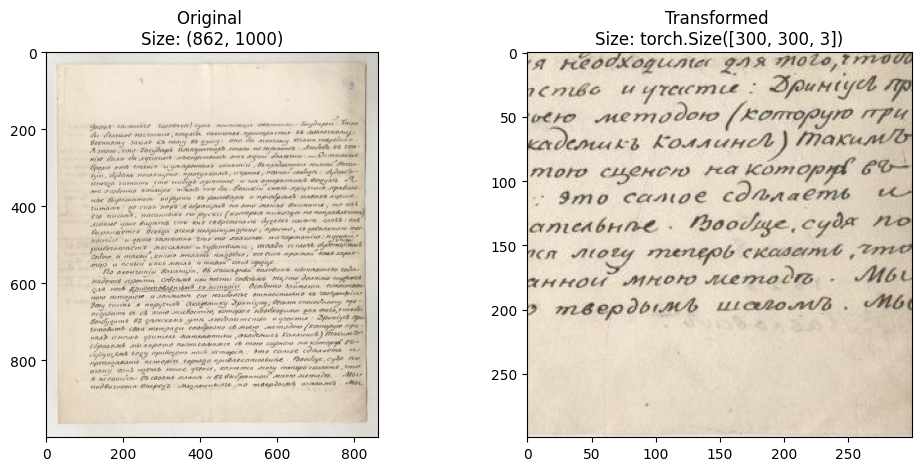

In [5]:
files_names = sorted(os.listdir(DATA_POS))
image_paths  = [os.path.join(DATA_POS, i) for i in files_names]

plot_transformed_images(image_paths, transform=data_transform)

# Dataloader

In [6]:
# https://stackoverflow-com.translate.goog/questions/51677788/data-augmentation-in-pytorch?_x_tr_sl=auto&_x_tr_tl=ru&_x_tr_hl=ru

# class experimental_dataset(Dataset):
#     def __init__(self, data, transform):
#         self.data = data
#         self.transform = transform

#     def __len__(self):
#         return len(self.data.shape[0])

#     def __getitem__(self, idx):
#         item = self.data[idx]
#         item = self.transform(item)
#         return item

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor()
# ])

# x = torch.rand(8, 1, 2, 2)
# print(x)

# dataset = experimental_dataset(x, transform)

# for item in dataset:
#     print(item)


In [7]:
def pos_neg(dataloader):
    num_pos = num_neg = num = 0

    for batch in dataloader:
        images, labels = batch
    
        col = images.size(0)
        pos = labels.sum()
        # print(images.size(0))
        
        num += col
        num_pos += pos
        num_neg += col - pos
    
    return {"1":num_pos.item(), "0":num_neg.item(), "total":num}

In [8]:
class Positive_Dataset(Dataset):
    def __init__(self, images_dir, augmentation=1, transform=data_transform):
        # self.images_dir = images_dir
        self.transform = transform
        self.augmentation = augmentation

        files_names = sorted(os.listdir(images_dir))
        self.image_paths = [os.path.join(images_dir, i) for i in files_names]
                           
        self.real_len = len(files_names)
            
    def __len__(self):
        return self.augmentation * len(self.image_paths)
                   
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx % self.real_len])
        
        # if idx < self.real_len:
        #     return transforms.ToTensor()(image), 1
        # else:
        return self.transform(image), 1


class Negative_Dataset(Dataset):
    def __init__(self, images_dir, transform=data_transform):
        self.transform = transform

        files_names = sorted(os.listdir(images_dir))
        self.image_paths = [os.path.join(images_dir, i) for i in files_names]
            
    def __len__(self):
        return len(self.image_paths)
                   
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        return self.transform(image), 0

In [9]:
my_pos = Positive_Dataset(DATA_POS, augmentation=100)
print(f"Positive: {len(my_pos)}")

my_neg = Negative_Dataset(DATA_NEG)
print(f"Negative: {len(my_neg)}")

Positive: 2300
Negative: 224


In [10]:
dataset = torch.utils.data.ConcatDataset([my_pos, my_neg])
print(f"ConcatDataset: {len(dataset)}")

ConcatDataset: 2524


In [11]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(dataset) * 0.8)
# в валидационную — остальные 20%
val_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
                    dataset, [train_size, val_size])

print(f"Train: {len(train_dataset)}\n Test: {len(test_dataset)}")

Train: 2019
 Test: 505


In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                                          shuffle=False)

print(f"Train batches: {len(train_loader)}\n Test batches: {len(test_loader)}")

Train batches: 253
 Test batches: 64


In [13]:
pos_neg(train_loader)

{'1': 1843, '0': 176, 'total': 2019}

In [14]:
pos_neg(test_loader)

{'1': 457, '0': 48, 'total': 505}

In [15]:
images, labels = next(iter(train_loader))
print(images.shape, labels)

torch.Size([8, 3, 300, 300]) tensor([0, 1, 1, 0, 1, 1, 0, 1])


In [16]:
def show_images(images, labels):
    f, axes= plt.subplots(1, 4, figsize=(30,10))
    
    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы) 
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

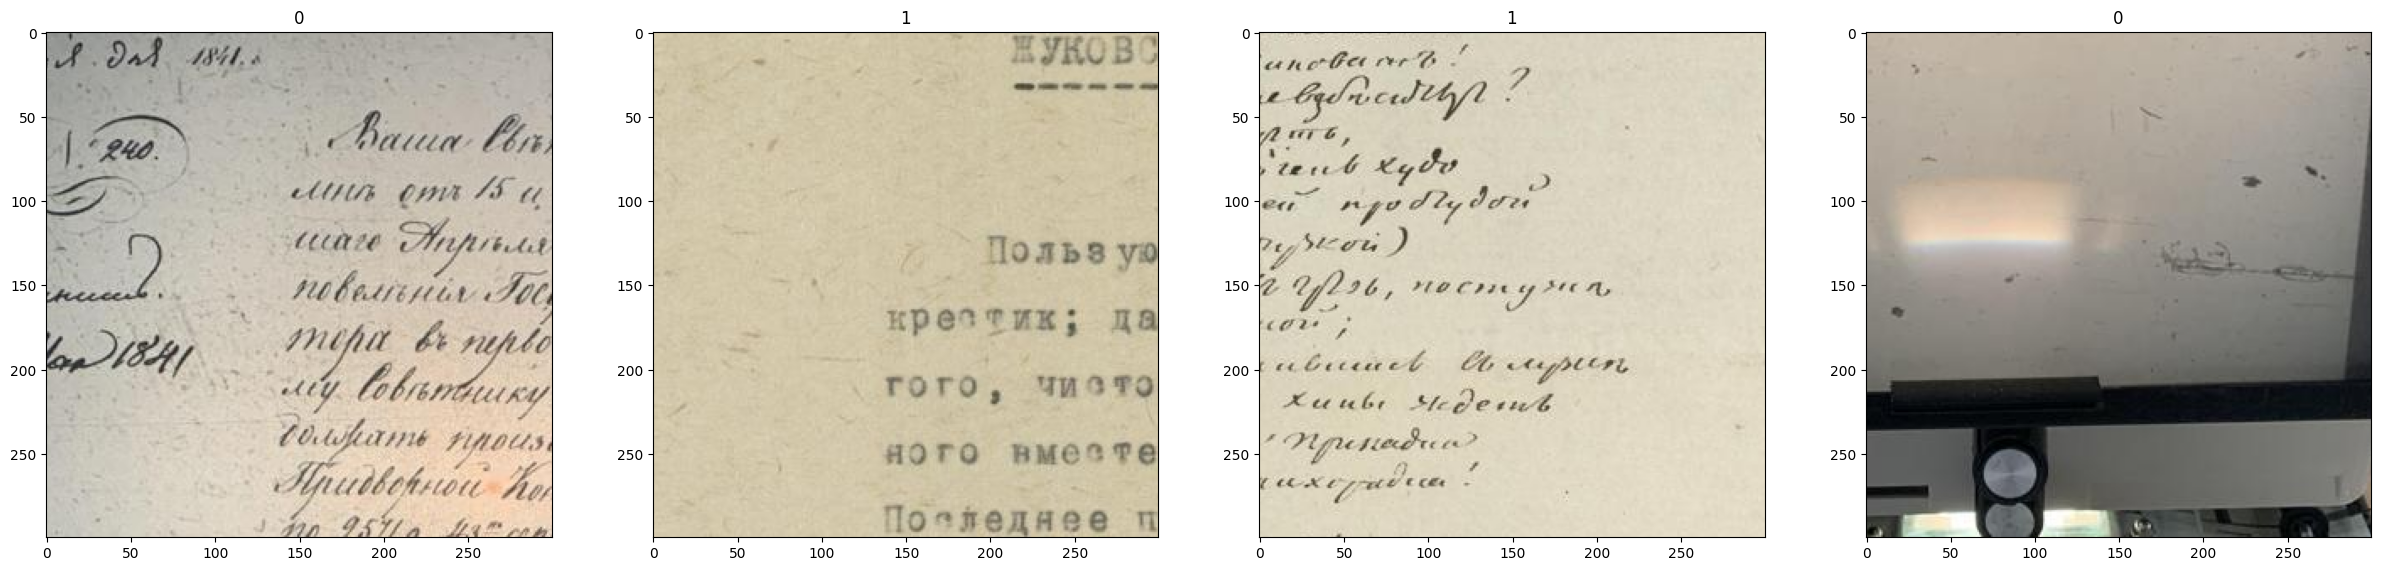

In [17]:
show_images(images, labels)

# Код

In [18]:
def evaluate(model, dataloader, loss_fn):

    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):

        # получаем текущий батч
        X_batch, y_batch = batch
        num_elements += len(y_batch)

        # эта строка запрещает вычисление градиентов
        with torch.no_grad():
            # получаем ответы сети на картинки батча
            logits = model(X_batch.to(device))

            # вычисляем лосс на текущем батче
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())

            # вычисляем ответы сети как номера классов для каждой картинки
            y_pred = torch.argmax(logits, dim=1)

            # вычисляем количество правильных ответов сети в текущем батче
            num_correct += torch.sum(y_pred.cpu() == y_batch)

    # вычисляем итоговую долю правильных ответов
    accuracy = num_correct / num_elements

    return accuracy.numpy(), np.mean(losses)

def train(model, train_loader, val_loader, loss_fn, optimizer, n_epoch=3):

    # цикл обучения сети
    for epoch in range(n_epoch):

        print("Epoch:", epoch+1)

        model.train(True)

        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(train_loader):
            # получаем текущий батч
            X_batch, y_batch = batch

            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))
            running_losses.append(loss.item())

            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            # вычислим accuracy на текущем train батче
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)

            # Логирование результатов
            if (i+1) % 50 == 0:
                print("Средние train лосс и accuracy на последних 50 итерациях:",
                      np.mean(running_losses), np.mean(running_accuracies), end='\n')

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        print("Эпоха {}/{}: val лосс и accuracy:".format(epoch+1, n_epoch,),
                      val_loss, val_accuracy, end='\n')

    return model

In [19]:
# ВАШ КОД: постройте и обучите нейросеть
# model.children() выдает список сабмодулей нейросети
# в нашем случае это блоки resnet

def create_model(model, num_freeze_layers, num_out_classes):
    # замена последнего слоя сети
    model.fc = nn.Linear(512, num_out_classes)

    # заморозка слоев
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

In [20]:
def get_predictions(model, dataloader):
    model.eval()
    predicted_labels = []
    true_labels = []

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        X_batch, y_batch = batch
        true_labels.append(y_batch)

        with torch.no_grad():
            logits = model(X_batch.to(device))
            y_pred = torch.argmax(logits, dim=1)
            predicted_labels.append(y_pred)
            
    predicted_labels = torch.cat(predicted_labels)
    true_labels = torch.cat(true_labels)
    return predicted_labels, true_labels

# train

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [22]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# list(model.children())

In [23]:
# dir(model)

In [24]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [25]:
num_layers = len(list(model.children()))
print(f"Число слоёв: {num_layers}")
num_classes = 2
print(f"Число классов: {num_classes}")

model = create_model(model, num_layers - 1, num_classes).to(device)

Число слоёв: 10
Число классов: 2


In [26]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [27]:
%time
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, train_loader, test_loader, loss_fn, optimizer, n_epoch=5)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 11.7 µs
Epoch: 1
Средние train лосс и accuracy на последних 50 итерациях: 0.3326167729496956 0.9175
Средние train лосс и accuracy на последних 50 итерациях: 0.3118265394866466 0.91375
Средние train лосс и accuracy на последних 50 итерациях: 0.30745763421058653 0.91083336
Средние train лосс и accuracy на последних 50 итерациях: 0.2945670806616545 0.910625
Средние train лосс и accuracy на последних 50 итерациях: 0.28743105018138887 0.9115
Эпоха 1/5: val лосс и accuracy: 0.24362399009987712 0.9049505
Epoch: 2
Средние train лосс и accuracy на последних 50 итерациях: 0.2856658774614334 0.9025
Средние train лосс и accuracy на последних 50 итерациях: 0.2518355695158243 0.91125
Средние train лосс и accuracy на последних 50 итерациях: 0.24997617920239767 0.9125
Средние train лосс и accuracy на последних 50 итерациях: 0.23944275967776776 0.916875
Средние train лосс и accuracy на последних 50 итерациях: 0.2408185405731201 0.9145
Эпоха 2/

# eval

In [28]:
y_pred, y_true = get_predictions(model, train_loader)
(y_pred == y_true).float().mean()

tensor(0.9648)

In [29]:
y_pred, y_true = get_predictions(model, test_loader)
(y_pred == y_true).float().mean()

tensor(0.9743)

In [41]:
def confusion_matrix(y_true, y_pred):
    cm = conf_matrix(y_true, y_pred) 
    
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, 
                annot=True,
                fmt='g',
                xticklabels=['0','1'],
                yticklabels=['0','1'])
    
    plt.xlabel('Prediction',fontsize=13)
    plt.ylabel('True',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.show()
    return cm

In [44]:
X_batch, y_batch = next(iter(loader))
X_batch.shape, y_batch

(torch.Size([8, 3, 300, 300]), tensor([1, 1, 1, 1, 1, 1, 1, 1]))

In [45]:
logits = model(X_batch.to(device))
logits, torch.softmax(logits, dim=1), torch.argmax(logits, dim=1), y_batch

(tensor([[-0.9425,  1.9466],
         [-0.7061,  1.3444],
         [-1.8269,  2.1630],
         [-0.8790,  2.1361],
         [-0.8665,  1.6163],
         [-0.5370,  1.4462],
         [-0.0622,  1.4507],
         [-0.4686,  1.5885]], grad_fn=<AddmmBackward0>),
 tensor([[0.0527, 0.9473],
         [0.1140, 0.8860],
         [0.0182, 0.9818],
         [0.0467, 0.9533],
         [0.0771, 0.9229],
         [0.1210, 0.8790],
         [0.1805, 0.8195],
         [0.1133, 0.8867]], grad_fn=<SoftmaxBackward0>),
 tensor([1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1]))

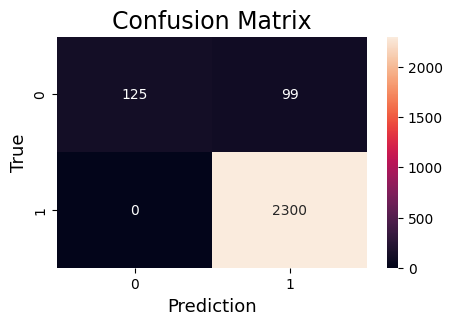

array([[ 125,   99],
       [   0, 2300]])

In [46]:
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                     shuffle=False)

y_pred, y_true = get_predictions(model, loader)
# (y_pred == y_true).float().mean()
confusion_matrix(y_true, y_pred)

# array([[  94,  130],
#        [   0, 2300]])

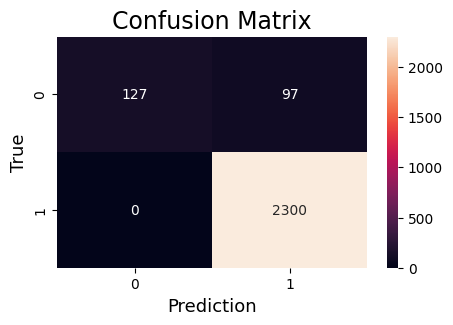

array([[ 127,   97],
       [   0, 2300]])

In [47]:
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                     shuffle=False)

y_pred, y_true = get_predictions(model, loader)
# (y_pred == y_true).float().mean()
confusion_matrix(y_true, y_pred)

In [48]:
# ((y_pred == 1) * (y_true == 1)).float().sum()

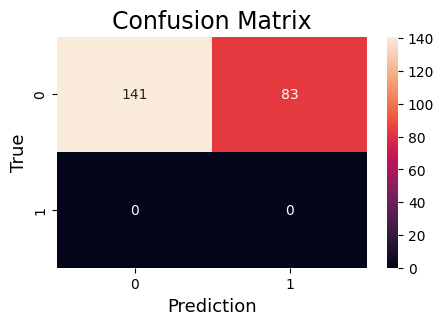

array([[141,  83],
       [  0,   0]])

In [49]:
neg_loader = torch.utils.data.DataLoader(my_neg, batch_size=BATCH_SIZE, 
                                          shuffle=False)

y_pred, y_true = get_predictions(model, neg_loader)
confusion_matrix(y_true, y_pred)
# array([[101, 123],
#        [  0,   0]])

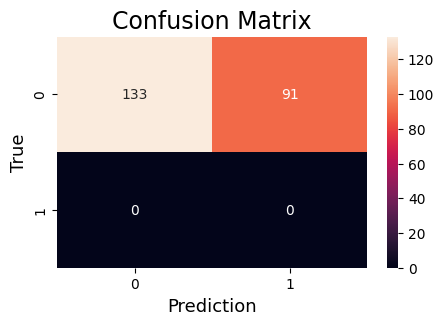

array([[133,  91],
       [  0,   0]])

In [50]:
neg_loader = torch.utils.data.DataLoader(my_neg, batch_size=BATCH_SIZE, 
                                          shuffle=False)

y_pred, y_true = get_predictions(model, neg_loader)
confusion_matrix(y_true, y_pred)

In [51]:
# my_neg.image_paths

In [52]:
os.listdir(DATA_POS)

['1 Ранний почерк-(хороший почерк)-1.jpg',
 '3 Поздний почерк-(хороший почерк)-0.JPG',
 '1 Ранний почерк-(хороший почерк)-2.jpg',
 '2 Зрелый почерк-(обычный почерк)-1.jpg',
 '2 Зрелый почерк-(Вяземскому? плохой почерк)-0.jpg',
 '2 Зрелый почерк-(обычный почерк)-2.jpg',
 '2 Зрелый почерк-(обычный почерк)-0.jpg',
 '3 Поздний почерк-(плохой почерк)-2.jpg',
 '3 Поздний почерк-(плохой почерк)-0.jpg',
 '1 Ранний почерк-(обычный почерк).jpg',
 '2 Зрелый почерк-(плохой почерк).jpg',
 '2 Зрелый почерк-(идеальный почерк)-0.jpeg',
 '2 Зрелый почерк-(идеальный почерк)-1.jpeg',
 '3 Поздний почерк-(плохой почерк)-1.jpg',
 '3 Поздний почерк-(хороший почерк)-2.JPG',
 '2 Зрелый почерк-(идеальный почерк)-2.jpeg',
 '3 Поздний почерк-(хороший почерк)-3.JPG',
 '1 Ранний почерк-(хороший почерк)-3.jpg',
 '2 Зрелый почерк-(идеальный почерк)-3.jpeg',
 '1 Ранний почерк-(хороший почерк)-0.jpg',
 '3 Поздний почерк-(хороший почерк)-1.JPG',
 '3 Поздний почерк-(обычный поч

In [53]:
os.listdir(DATA_NEG)

['68-66.JPG',
 '68-2.JPG',
 '37-19.JPG',
 '37-14.JPG',
 '2348-3.JPG',
 '2348-12.JPG',
 '68-52.JPG',
 '68-54.JPG',
 '68-21.JPG',
 '68-46.JPG',
 '68-41.JPG',
 '2013-27.JPG',
 '2348-6.JPG',
 '2348-49.JPG',
 '68-45.JPG',
 '68-39.JPG',
 '2348-11.JPG',
 '2348-19.JPG',
 '68-53.JPG',
 '2013-0.JPG',
 '68-64.JPG',
 '68-15.JPG',
 '122-0.JPG',
 '2348-28.JPG',
 '68-49.JPG',
 '37-4.JPG',
 '2348-43.JPG',
 '2348-20.JPG',
 '68-18.JPG',
 '68-38.JPG',
 '2013-15.JPG',
 '2013-5.JPG',
 '142-24.JPG',
 '2348-34.JPG',
 '68-9.JPG',
 '68-59.JPG',
 '2013-3.JPG',
 '68-55.JPG',
 '2348-25.JPG',
 '2013-10.JPG',
 '2013-2.JPG',
 '142-5.JPG',
 '662-1.JPG',
 '2013-22.JPG',
 '37-8.JPG',
 '142-27.JPG',
 '142-9.JPG',
 '2348-39.JPG',
 '142-14.JPG',
 '142-26.JPG',
 '68-61.JPG',
 '2348-30.JPG',
 '2348-14.JPG',
 '142-10.JPG',
 '142-13.JPG',
 '68-37.JPG',
 '2348-42.JPG',
 '68-33.JPG',
 '68-14.JPG',
 '68-0.JPG',
 '2348-47.JPG',
 '662-0.JPG',
 '2348-15.JPG',
 '2348-40.JPG',
 '2013-13.JPG',
 '142-3.JPG',
 '122-9.JPG',
 '68-10.JPG',